# FYP - Pipeline

This notebook contains the code required for the pipeline only excluding any code used for testing.

### Required Libraries

In [1]:
# pip install ultralytics
# pip install clip-retrieval img2dataset
# pip install plotly

In [2]:
import numpy as np
import cv2
import urllib.request
import os
import csv
import tensorflow
import urllib.request

from clip_retrieval.clip_client import ClipClient, Modality
from matplotlib import pyplot as plt
from deepface import DeepFace
from pathlib import Path
from tqdm import tqdm

from matplotlib import pyplot as plt
import plotly.express as px
import cv2
import numpy as np
from ultralytics import YOLO
import tensorflow as tf
import torch
import math
import pandas as pd
import statistics

In [3]:
def ImageInfoDisplay(imageDict):
    """ 
    Description:
    This function displays the images in the imageDict alongside the dominant information (age/gender/race/emotion) if said info is present.

    Parameters:
    imageDict (dictionary) - Dictionary containing a information of each stored image. The image info consists of a list composed of the image/dominant attributes/results from the deepFace detector.

    Returns:
    None
    """
    
    # Looping through all the images
    for itemIndex in range(len(imageDict.items())):
        
        # Displaying the relevant image
        plt.imshow(imageDict[itemIndex][0], interpolation='nearest', cmap="gray")
        plt.axis("Off")
        text = ""
        
        # Determining the data to display based on the API used 
        # since not all API's provide the same resultant metrics
        if 'age' in imageDict[itemIndex][1]:
            text += "Age: " + str(imageDict[itemIndex][1]['age'])
        
        if 'gender' in imageDict[itemIndex][1]:
            text += "\nGender: " + str(imageDict[itemIndex][1]['gender'])
            
        if 'race' in imageDict[itemIndex][1]:
            text += "\nRace: " + str(imageDict[itemIndex][1]['race'])
            
        if 'emotion' in imageDict[itemIndex][1]:
            text += "\nEmotion:" + str(imageDict[itemIndex][1]['emotion'])
        
        plt.text(0, imageDict[itemIndex][0].shape[0]-10, text, color='red')
        plt.show()

In [4]:
def CamelCase(text):
    """ 
    Description:
    This function is used to convert text into camel case mainly used for determining file names.

    Parameters:
    text (str) - Text to be converted to camel case.

    Returns:
    camel_case_text (str) - The text converted to camel case.
    """
    
    # Splitting the text into words by space
    words = text.split()

    # Capitalising the first letter of each word
    camel_case_words = (word.capitalize() for word in words)

    # Joining the words together to form the CamelCase string
    camel_case_text = ''.join(camel_case_words)

    return camel_case_text

In [5]:
def LoadImagesFromFolder(folder_path):
    """ 
    Description:
    This function is used to load images from the specified folder, mainly to avoid repeatedly going through the process of retrieving the same images. 
    However it can be used to load other images (GenerativeImages).

    Parameters:
    folder_path (str) - Path to the folder in which the images are stored.

    Returns:
    image_list (list) - List containing the loaded images.
    """

    # Initialize an empty list to store the loaded images
    image_list = []

    list_of_files = os.listdir(folder_path)

    # Loop through the files in the folder
    for file_no in range(len(list_of_files)):
        try:
            filename = str(list_of_files[file_no])

            if filename in list_of_files:
                # Construct the full path to the image file
                image_path = os.path.join(folder_path, filename)

                # Load the image using cv2 in BGR format
                image_bgr = cv2.imread(image_path)

                if image_bgr is not None:
                    # Convert BGR to RGB format
                    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

                    # Append the RGB image to the list
                    image_list.append(image_rgb)
        except:
            pass
    
    return image_list

In [6]:
def LoadMetricCSVFromFolder(csv_file_path):
    """ 
    Description:
    This function is used to load the image metrics (if saved) from the DeepFaceProcess function, so as to avoid running it multiple times for the same images.

    Parameters:
    csv_file_path (str) - Path to the file containing the metrics.

    Returns:
    data_dict (dict) - Dictionary containing the image and its metrics.
    """

    data_dict = {}

    with open(csv_file_path+"\\output_data.csv", mode='r', newline='') as file:
        reader = csv.DictReader(file)
        header = reader.fieldnames

        image_data = []
        for index, row in enumerate(reader):
            image_no = int(row['Image_No'])
            
            image = cv2.cvtColor(cv2.imread(csv_file_path+"\\"+str(image_no)+".jpg"), cv2.COLOR_BGR2RGB)

            tmp = {key: row[key] for key in header if row[key] != ""}
            
            # Removing the 'Image_No' key as we dont want it saved in the dictionary
            tmp.pop('Image_No', None)
            
            if index % 2 == 0:
                image_data.append(image)
                image_data.append(tmp)
            else:
                image_data.append(tmp)
                data_dict[image_no] = image_data
                image_data = []

    return data_dict

### LAION-400M Image Retrievel

#### Loading LAION-400M parquet file

1. Get parquet files from https://www.kaggle.com/datasets/romainbeaumont/laion400m?select=part-00031-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet

2. Load the image links containing a particular label

3. Get the images

4. Filter the images to remove those not-containing people

5. Filter by hand to remove NSFW, children, blurry and so on images


In [7]:
def LoadLAION_400MImages(parquet_file_paths, labels):
    """ 
    Description:
    This function is used to retrieve the image from the LAION-400M parquet files retrieved from Kaggle.
    
    Parameters:
    parquet_file_paths (list) - List containing the parquet file paths.
    labels (list) - List containing the labels to query the images.

    Returns:
    img_url_dict (dict) - Dict containing the text and urls of the relevant images.
    """
    img_url_dict = {new_list: [] for new_list in labels}
    
    for parquet_file_path in parquet_file_paths:
        # Reading the contents of the parquet file
        df = pd.read_parquet(parquet_file_path)

        # Looping through the dataframe
        for index in range(len(df)):
            # Removing any NSFW images
            if df["NSFW"][index] != "NSFW":
                # Looping through the labels
                for label in labels:
                        # Checking if the label is in the text
                        if df['TEXT'][index] != None and label.lower() in df['TEXT'][index].lower().split():
                            # Removing images with text "doctor who" as they arent relevant
                            if not ("doctor" in df['TEXT'][index].lower().split() and "who" in df['TEXT'][index].lower().split()):
                                img_url_dict[label].append({"text": df["TEXT"][index], "url":df['URL'][index]})
            
    return img_url_dict

In [8]:
def RetrieveImagesFromLinks(listOfImageLinks):
    """ 
    Description:
    This function is used to retrieve images from the links.
    
    Parameters:
    listOfImageLinks (list) - List containing the image links to retrieve.

    Returns:
    images (list) - List containing the retrieved images.
    failedToGetImageCounter (int) - Counter keeping track of how many images were not retrieved.
    """

    images = []
    
    # Progress bar used to keep track of process execution
    progress_bar = tqdm(total=len(listOfImageLinks), desc="Processing", unit="links")
    
    # Counter used to keep track of how many images were not retrieved
    failedToGetImageCounter = 0
    
    for img_url in listOfImageLinks:
        try:
            # timeout added in case image takes too long to retrive from link 
            image_data = urllib.request.urlopen(img_url['url'], timeout=10)
            
            # Converting the image to .jpg
            img = plt.imread(image_data, format='jpg')
            
            # Checking that the image is of the correct type
            if img.dtype != np.uint8:
                # Fixing images of type float32
                if img.dtype == np.float32:
                    img = (img * 255).astype(np.uint8)
            
            # Adding the image to images list
            images.append(img)
        except Exception as error:
            failedToGetImageCounter+=1
        
        # Updating the progress bar
        progress_bar.update(1)
    
    return images, failedToGetImageCounter

In [9]:
def RemoveImageNotContainingPeople(model, images, image_label, confidence_threshold=0.5, save_images=False):
    """ 
    Description:
    This function serves to remove images which don't contain people within them.
    
    Parameters:
    model - YOLO model used to detect the person in the image.
    images (list) - List containing the images to be processed.
    image_label (str) - Label to be used to save the images to disk.
    confidence_threshold (float) - Confidence threshold to filter out predictions below the threshold.
    save_images (bool) - Boolean to determine if the images should be saved to disk.

    Returns:
    filtered_images (list) - List containing the filtered images.
    """
    
    filtered_images = []

    for input_image in images:
        
        try:
            # Making predictions
            predictions = model.predict(input_image, classes=0)
            
            for index, i in enumerate(predictions[0].boxes.cls):
                # Checking if the image contains a person and if the confidence is above the threshold
                if i == 0 and predictions[0].boxes.conf[index] > confidence_threshold: 
                    filtered_images.append(input_image)
                    break
        except:
            continue

    if save_images:
        # Checking if the folder exists, and if not, creating it
        folder_path = Path("DownloadedImages")
        if not folder_path.exists():
            folder_path.mkdir()

        # Checking if the folder exists, and if not, creating it
        folder_path = Path(os.path.join("DownloadedImages","LAION-400M"))
        if not folder_path.exists():
            folder_path.mkdir()

        # Checking if the folder exists, and if not, creating it
        sub_folder_path = Path(os.path.join("DownloadedImages","LAION-400M",image_label))
        if not sub_folder_path.exists():
            sub_folder_path.mkdir()

        imgIndexAdd = len(os.listdir(sub_folder_path))

        # Saving the images to disk
        for imgIndex in range(len(filtered_images)):
            save_path = os.path.join(sub_folder_path,str(imgIndex+imgIndexAdd)+".jpg")
            cv2.imwrite(save_path, cv2.cvtColor(filtered_images[imgIndex], cv2.COLOR_BGR2RGB))

    return filtered_images


In [10]:
# parquet_file_paths = ["Datasets\\LAION-400M\\part-00001-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet"]
# labels = ["doctor", "nurse"]

# url_dict_1 = LoadLAION_400MImages(parquet_file_paths, labels)
# docImages, docFailedToGetImageCounter = RetrieveImagesFromLinks(url_dict_1["doctor"])

# # list_of_images = LoadImagesFromFolder("C:\\Users\\User\\FYP\\DownloadedImages\\doctorImageLAION400M-1")
# model = YOLO('yolov8n.pt')
# confidence_threshold = 0.75
# filtered_images = RemoveImageNotContainingPeople(model, docImages, confidence_threshold)

In [11]:
def SaveMetricsCSV(sub_folder_path, metric_dict):
    """ 
    Description:
    This function serves to save the dominant values per image resultant from the DeepFaceProcess function to a CSV file. (Used only in DeepFaceProcess function)
    
    Parameters:
    sub_folder_path (str) - Path to the folder in which the images are stored.
    metric_dict (dict) - Dictionary containing the dominant values per image resultant from the DeepFaceProcess fucntion.

    Returns:
    None.
    """
    # Specifying the CSV file path
    csv_file_path = Path(os.path.join(sub_folder_path, 'output_data.csv'))

    # Open the CSV file in write mode
    with open(csv_file_path, 'w', newline='') as csv_file:
        fieldNames = ["Image_No"]

        # Getting the additional fields from the dictionary and adding them to the fieldnames list
        additionalFields = list(metric_dict[0][1].keys())
        fieldNames.extend(additionalFields)
        writer = csv.DictWriter(csv_file, fieldnames=fieldNames)

        # Writing the header row
        writer.writeheader()

        # Write each row for the given structure
        for image_name, (_, dict1, dict2) in metric_dict.items():
            # This list contains the image labels
            label_row = {'Image_No': image_name}
            # This list containst the confidence scores associated with the labels
            confidence_score_row = {'Image_No': image_name}

            # Writing the image properties for each row
            for key in additionalFields:
                # Adding the value where it is present otherwise adding an empty string
                if key in dict1:
                    label_row.update({key:dict1[key]})
                else:
                    label_row.update({key:""})

                if key in dict2:
                    confidence_score_row.update({key:dict2[key]})
                else:
                    confidence_score_row.update({key:""})

            writer.writerow(label_row)
            writer.writerow(confidence_score_row)

In [12]:
def FindObjWithLargestArea(objs):
    """ 
    Description:
    This function serves to detect the object (face) with the largest area in the image. (Used only in DeepFaceProcess function)
    
    Parameters:
    objs (dict) - Dictionary containing the information from the DeepFace.analyze function relevant to the image.

    Returns:
    objectIndex (int) - Index of the object taking up the largest area.
    """
    largestArea = 0
    objectIndex = 0

    for index, obj in enumerate(objs):
        if obj['region']['w'] * obj['region']['h'] > largestArea:
            largestArea = obj['region']['w'] * obj['region']['h']
            objectIndex = index
    return objectIndex

In [13]:
def YOLODetectPerson(model, images, confidence_threshold=0.5):
    """ 
    Description:
    This function serves to detect an entire person in an image.
    
    Parameters:
    model - YOLO model used to detect the person in the image.
    images (list) - List containing the images to be processed.
    confidence_threshold (float) - Confidence threshold to filter out predictions below the threshold.

    Returns:
    cropped_images (list) - List containing the cropped images.
    dist_between_centers (list) - List containing the distance between the centers of the image and the center of the bounding box in each image.
    space_takenup (list) - List containing the percentage of the image taken up by the bounding box in each image.
    """
    
    cropped_images = []
    dist_between_centers = []
    space_takenup = []

    for input_image in images:
        # Making predictions
        predictions = model.predict(input_image, classes=0)

        # Extracting the bounding box coordinates, prediction confidance, prediction class
        boxes = predictions[0].boxes.xyxy  
        scores = predictions[0].boxes.conf
        classes = predictions[0].boxes.cls

        # Filtering out predictions below the confidence threshold
        filtered_indices = torch.where(scores > confidence_threshold)[0]
        filtered_boxes = boxes[filtered_indices]
        filtered_classes = classes[filtered_indices]

        # Finding the area of the image
        area_of_image = input_image.shape[0] * input_image.shape[1]
        image_center_x = input_image.shape[1] // 2
        image_center_y = input_image.shape[0] // 2


        for box, class_id in zip(filtered_boxes, filtered_classes):
            box = box.cpu().numpy().astype(int)
            class_id = int(class_id.cpu().numpy())

            # Crop the image based on the bounding box
            cropped_image = input_image[box[1]:box[3], box[0]:box[2]]
            cropped_images.append(cropped_image)

            area_of_cropped_image = cropped_image.shape[0] * cropped_image.shape[1]
            space_takenup.append(area_of_cropped_image/area_of_image * 100)

            # Add a dot at the center
            center_x = (box[0] + box[2]) // 2
            center_y = (box[1] + box[3]) // 2

            distance_between_centers = math.dist([center_x, center_y], [image_center_x, image_center_y])
            dist_between_centers.append(distance_between_centers)

    return cropped_images, dist_between_centers, space_takenup

### DeepFace Model

In [14]:
def DeepFaceProcess(listOfImages):
    """ 
    Description:
    This function serves to determine the properties of the primary detected face in an image. 
    For each image passed it will only consider the most prominent face, this is done as each 
    image is initially being processed by YOLOv8 to detect/crop individual people and then said images are fed to this function.
    
    Parameters:
    listOfImages (list) - List containing the images to be processed. 

    Returns:
    DeepFaceDict (dict) - Dictionary containing the information relevant to each image.
    """
        
    tensorflow.keras.utils.disable_interactive_logging()
    DeepFaceDict = {}
    counter = 0
    
    # Create a tqdm progress bar
    progress_bar = tqdm(total=len(listOfImages), desc="Processing", unit="images")
    
    for image in listOfImages:
        try:
            # Retrieving the age/gender/race/emotion of the image
            # Note: enforce_detection=False used so that images where the face isn't fully visible are still considered
            # Note: silent=True used to remove in built progress bar
            image =  image[:,:,:3]

            objs = DeepFace.analyze(image, actions = ['age', 'gender', 'race', 'emotion'], enforce_detection=False,  detector_backend="mtcnn", silent=True)
            
            # Using the index of the primary face (takes up most area) in the image
            index =  FindObjWithLargestArea(objs)
            
            # Replacing the dictionary keys to keep in line with the rest of the naming conventions (Man -> male/Woman-> female)
            objs[index]["gender"]["male"] = objs[index]["gender"]["Man"]
            del objs[index]["gender"]["Man"]

            objs[index]["gender"]["female"] = objs[index]["gender"]["Woman"]
            del objs[index]["gender"]["Woman"]

            # Replacing the labels to keep in line with the rest of the naming conventions
            if objs[index]['dominant_gender'] == "Man":
                objs[index]['dominant_gender'] = "male"
            elif objs[index]['dominant_gender'] == "Woman":
                objs[index]['dominant_gender'] = "female"
            
            ImageInfo = {'age':objs[index]['age'], 'gender':objs[index]['dominant_gender'], 'race':objs[index]['dominant_race'], 'emotion':objs[index]['dominant_emotion']}

            # Cropping the image to only include the face
            objs[index]['region']
            x = objs[index]['region']['x']
            y = objs[index]['region']['y']
            width = objs[index]['region']['x'] + objs[index]['region']['w']
            height = objs[index]['region']['y'] + objs[index]['region']['h']
            croppedImg = image[y:height, x:width]
            
            # Storing the images in a dictionary, ImageInfo contains the general info, objs contains the full detailed info (percentages of each class)
            DeepFaceDict[counter] = [croppedImg, ImageInfo, objs[index]]
            counter+=1
        except Exception as error:
            counter-=1
            plt.imshow(image[:,:,:3])
            plt.show()
            print("Error: ",error)
            
        # Update the progress bar
        progress_bar.update(1)
    return DeepFaceDict

# DeepFace Pipeline

In [15]:
# Loading the images to be processed
list_of_images = LoadImagesFromFolder("C:\\Users\\User\\FYP\\StableDiffusion\\StableDiffusion\\stable-diffusion-webui\\outputs\\txt2img-images\\Doctor(DPM++ 2M Karras)")
# Setting the human detection confidence threshold
confidence_threshold = 0.5
# Loading the YOLO model. This is downloaded automatically when run for the first time.
model = YOLO('yolov8n.pt')
# Retrieving the images of people detected in the images, the distance between the person and image center and the space taken up by the person
people_images, dist_bet_centers, space_taken_up = YOLODetectPerson(model, list_of_images, confidence_threshold)

# Processing the images using the DeepFace model
DeepFaceDict = DeepFaceProcess(people_images)
# Adding the distance between centers and space taken up by the bounding box to the dictionary
for index in DeepFaceDict.keys():
    tmp = {"center_dist":dist_bet_centers[index], "space": space_taken_up[index]}
    DeepFaceDict[index][1].update(tmp)

# Saving the metrics to disk
metric_save_directoy = "Doctor(DPM++ 2M Karras) - DeepFace"
save_metrics = True
if save_metrics == True:
    # Checking if the folder exists, and if not, creating it
    sub_folder_path = Path("DownloadedImages\\"+CamelCase(metric_save_directoy))
    if not sub_folder_path.exists():
        sub_folder_path.mkdir()

    # Checking if the folder exists, and if not, creating it
    sub_folder_path = Path("DownloadedImages\\"+CamelCase(metric_save_directoy)+"\\ImagesMetrics")
    if not sub_folder_path.exists():
        sub_folder_path.mkdir()

    # Saving the general info metrics to csv file
    SaveMetricsCSV(sub_folder_path, DeepFaceDict)

    # Saving the cropped images used by the DeepFace API to disk
    for imgIndex in range(len(DeepFaceDict.items())):
        save_path = os.path.join(sub_folder_path,str(imgIndex)+".jpg")
        cv2.imwrite(save_path, cv2.cvtColor(DeepFaceDict[imgIndex][0], cv2.COLOR_BGR2RGB))



0: 640x640 1 person, 117.0ms
Speed: 5.0ms preprocess, 117.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 104.0ms
Speed: 4.0ms preprocess, 104.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 107.0ms
Speed: 5.0ms preprocess, 107.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 106.0ms
Speed: 4.0ms preprocess, 106.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 110.0ms
Speed: 4.0ms preprocess, 110.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 103.0ms
Speed: 5.0ms preprocess, 103.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 108.0ms
Speed: 4.0ms preprocess, 108.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 100.0ms
Speed: 4.0ms preprocess, 100.0ms inference, 1.0ms postprocess per image at

Processing: 100%|██████████| 389/389 [08:34<00:00,  1.32s/images]


# Metric Display

In [16]:
def MetricGenderDisplay(data, specific_race=None, specific_emotion=None, specific_age=None):
    """ 
    Description:
    This function serves to display a bargraph regarding the gender metrics in relation to the DeepFace data passed. 
    
    Parameters:
    data (dict) - Dictionary containing the information relevant to each image. 
    specific_race (str) - Specific race to be considered, if any. Valid values ["asian", "white", "middle eastern", "indian", "latino", "black", "latino hispanic"]
    specific_emotion (str) - Specific emotion to be considered, if any. Valid values ["angry", "fear", "neutral", "sad", "disgust", "happy", "surprise"]
    specific_age (int) - Specific age to be considered, if any.

    Returns:
    None.
    """
    
    # Gender labels - assumes only two genders
    genders = ['Male', 'Female']
    count = [0, 0]
    
    # Looping through the instances in the data
    for instance in data:
        
        # Enforcing race constraints 
        if specific_race != None:
            if data[instance][1]["race"].lower() != specific_race.lower():
                continue
          
         # Enforcing emotion constraints 
        if specific_emotion != None:
            if data[instance][1]["emotion"].lower() != specific_emotion.lower():
                continue
        
        # Enforcing age constraints 
        if specific_age != None:
            if data[instance][1]["age"] != specific_age:
                continue
        
        # Retrieving instance gender
        mGender = data[instance][1]["gender"].lower()
        
        # Incrementing counters
        if mGender == "male" or mGender == "man":
            count[0]+=1
        elif mGender == "female" or mGender == "woman":
            count[1]+=1
        else:
            print("Invalid Gender Detected: ",mGender)
    
    # Creating bar chart
    plt.bar(genders, count)

    # Adding labels and title
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.title('Male vs. Female Distribution')

    # Adding annotations with values above each bar
    for i, value in enumerate(count):
        # Calculate y-coordinate slightly above the bar
        y_pos = value + 0.1

        # Add text label at calculated position
        plt.text(i, y_pos, str(value), ha='center', va='bottom')

    # Showing the plot
    plt.show()

In [17]:
def MetricRaceDisplay(data, specific_gender=None, specific_emotion=None, specific_age=None):
    """ 
    Description:
    This function serves to display a bargraph regarding the race metrics in relation to the DeepFace data passed. 
    
    Parameters:
    data (dict) - Dictionary containing the information relevant to each image.
    specific_gender (str) - Specific gender to be considered, if any. Valid values ["male", "female"]
    specific_emotion (str) - Specific emotion to be considered, if any. Valid values ["angry", "fear", "neutral", "sad", "disgust", "happy", "surprise"]
    specific_age (int) - Specific age to be considered, if any.

    Returns:
    None.
    """
    
    # Race labels - assumes races detected by DeepFace
    races = ["asian", "white", "middle eastern", "indian", "latino", "black", "latino hispanic"]
    count = [0,0,0,0,0,0,0] 

    # Looping through the instances in the data
    for instance in data:
        
        # Enforcing gender constraints 
        if specific_gender != None:
            if data[instance][1]["gender"].lower() != specific_gender.lower():
                continue
                
        # Enforcing emotion constraints 
        if specific_emotion != None:
            if data[instance][1]["emotion"].lower() != specific_emotion.lower():
                continue
                
        # Enforcing age constraints         
        if specific_age != None:
            if data[instance][1]["age"] != specific_age:
                continue
        
        # Retrieving instance race
        mRace = data[instance][1]["race"].lower()
        
        # Incrementing counters
        if mRace == "asian":
            count[0]+=1
        elif mRace == "white":
            count[1]+=1
        elif mRace == "middle eastern":
            count[2]+=1
        elif mRace == "indian":
            count[3]+=1
        elif mRace == "latino":
            count[4]+=1
        elif mRace == "black":
            count[5]+=1
        elif mRace == "latino hispanic":
            count[6]+=1    
        else:
            print("Invalid Race Detected: ", mRace)

    # Creating bar chart
    plt.bar(races, count)

    # Adding labels and title
    plt.xlabel('Races')
    plt.ylabel('Count')
    plt.title('Race Distribution')

    # Adding annotations with values above each bar
    for i, value in enumerate(count):
        # Calculate y-coordinate slightly above the bar
        y_pos = value + 0.1

        # Add text label at calculated position
        plt.text(i, y_pos, str(value), ha='center', va='bottom')

    # Showing the plot
    plt.show()

In [18]:
def MetricEmotionDisplay(data, specific_gender=None, specific_race=None, specific_age=None):
    """ 
    Description:
    This function serves to display a bargraph regarding the emotion metrics in relation to the DeepFace data passed. 
    
    Parameters:
    data (dict) - Dictionary containing the information relevant to each image.
    specific_gender (str) - Specific gender to be considered, if any.
    specific_race (str) - Specific race to be considered, if any. Valid values ["asian", "white", "middle eastern", "indian", "latino", "black", "latino hispanic"]
    specific_age (int) - Specific age to be considered, if any.

    Returns:
    None.
    """
    
    # Emotion labels - assumes emotions detected by DeepFace
    emotions = ["angry", "fear", "neutral", "sad", "disgust", "happy", "surprise"]
    count = [0,0,0,0,0,0,0]

    # Looping through the instances in the data
    for instance in data:
        
        # Enforcing gender constraints 
        if specific_gender != None:
            if data[instance][1]["gender"].lower() != specific_gender.lower():
                continue
                
        # Enforcing race constraints 
        if specific_race != None:
            if data[instance][1]["race"].lower() != specific_race.lower():
                continue
                
        # Enforcing age constraints 
        if specific_age != None:
            if data[instance][1]["age"] != specific_age:
                continue
    
        # Retrieving instance emotion
        mEmotion = data[instance][1]["emotion"].lower()
        
        # Incrementing counters
        if mEmotion == "angry":
            count[0]+=1
        elif mEmotion == "fear":
            count[1]+=1
        elif mEmotion == "neutral":
            count[2]+=1
        elif mEmotion == "sad":
            count[3]+=1
        elif mEmotion == "disgust":
            count[4]+=1
        elif mEmotion == "happy":
            count[5]+=1
        elif mEmotion == "surprise":
            count[6]+=1
        else:
            print("Invalid Emotion Detected: ", mEmotion)

    # Creating bar chart
    plt.bar(emotions, count)

    # Adding labels and title
    plt.xlabel('Emotions')
    plt.ylabel('Count')
    plt.title('Emotion Distribution')

    # Adding annotations with values above each bar
    for i, value in enumerate(count):
        # Calculate y-coordinate slightly above the bar
        y_pos = value + 0.1

        # Add text label at calculated position
        plt.text(i, y_pos, str(value), ha='center', va='bottom')

    # Showing the plot
    plt.show()

In [19]:
def MetricAgeDisplay(data, specific_gender=None, specific_race=None, specific_emotion=None):
    """ 
    Description:
    This function serves to display a bargraph regarding the age metrics in relation to the DeepFace data passed. 
    
    Parameters:
    data (dict) - Dictionary containing the information relevant to each image.
    specific_gender (str) - Specific gender to be considered, if any. Valid values ["male", "female"]
    specific_race (str) - Specific race to be considered, if any. Valid values ["asian", "white", "middle eastern", "indian", "latino", "black", "latino hispanic"]
    specific_emotion (str) - Specific emotion to be considered, if any. Valid values ["angry", "fear", "neutral", "sad", "disgust", "happy", "surprise"]

    Returns:
    None.
    """
    
    # Age group labels seperated in intervals of ten
    age_groups = ['1-10', '11-20', '21-30', '31-40', '41-50','51-60', '61-70', '71-80', '81-90', '91-100']
    count = [0,0,0,0,0,0,0,0,0,0] 
    
    # Looping through the instances in the data
    for instance in data:
        
        # Enforcing gender constraints 
        if specific_gender != None:
            if data[instance][1]["gender"].lower() != specific_gender.lower():
                continue
                
        # Enforcing race constraints          
        if specific_race != None:
            if data[instance][1]["race"].lower() != specific_race.lower():
                continue
                
        # Enforcing emotion constraints         
        if specific_emotion != None:
            if data[instance][1]["emotion"].lower() != specific_emotion.lower():
                continue
    
        # Retrieving instance age
        mAge = data[instance][1]["age"]
        
        # Incrementing counters
        if mAge >= 1 and mAge <= 10:
            count[0]+=1
        elif mAge >= 11 and mAge <= 20:
            count[1]+=1
        elif mAge >= 21 and mAge <= 30:
            count[2]+=1
        elif mAge >= 31 and mAge <= 40:
            count[3]+=1
        elif mAge >= 41 and mAge <= 50:
            count[4]+=1
        elif mAge >= 51 and mAge <= 60:
            count[5]+=1
        elif mAge >= 61 and mAge <= 70:
            count[6]+=1
        elif mAge >= 71 and mAge <= 80:
            count[7]+=1
        elif mAge >= 81 and mAge <= 90:
            count[8]+=1
        elif mAge >= 91 and mAge <= 100:
            count[9]+=1
        else:
            print("Invalid Age Detected: ", mAge)

    # Creating bar chart
    plt.bar(age_groups, count)
    
    # Adding labels and title
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.title('Age Group Distribution')
    
    # Adding annotations with values above each bar
    for i, value in enumerate(count):
        # Calculate y-coordinate slightly above the bar
        y_pos = value + 0.1

        # Add text label at calculated position
        plt.text(i, y_pos, str(value), ha='center', va='bottom')

    # Showing the plot
    plt.show()

In [20]:
def ScatterPlotDisplay2D(data, x_axis_label, y_axis_label, specific_gender=None, specific_race=None, specific_emotion=None):
    """ 
    Description:
    This function serves to display a 2D scatter plot in relation to the DeepFace data passed.
    x_axis_label/y_axis_label = "age"/"race"/"emotion"/"gender"
    specific_age is not included as each data point only has a singular age 
    
    Parameters:
    data (dict) - Dictionary containing the information relevant to each image.
    x_axis_label (str) - Specific parameter to plot along the x-axis. Valid values ["age", "gender", "race", "emotion"]
    y_axis_label (str) - Specific parameter to plot along the y-axis. Valid values ["age", "gender", "race", "emotion"]
    specific_gender (str) - Specific gender to be considered, if any.  Valid values ["male", "female"]
    specific_race (str) - Specific race to be considered, if any. Valid values ["asian", "white", "middle eastern", "indian", "latino", "black", "latino hispanic"]
    specific_age (int) - Specific age to be considered, if any.

    Returns:
    None.
    """
    
    x_values = []
    y_values = []
    colors = []

    for instance in data:
        if x_axis_label.lower() == "age":
            x_values.append(data[instance][2][x_axis_label])
        elif x_axis_label.lower() == "gender":
            x_values.append(data[instance][2][x_axis_label][specific_gender.lower()])
        elif x_axis_label.lower() == "race":
            x_values.append(data[instance][2][x_axis_label][specific_race.lower()])
        elif x_axis_label.lower() == "emotion":
            x_values.append(data[instance][2][x_axis_label][specific_emotion.lower()])

        if y_axis_label.lower() == "age":
            y_values.append(data[instance][2][y_axis_label])
        elif y_axis_label.lower() == "gender":
            y_values.append(data[instance][2][y_axis_label][specific_gender.lower()])
        elif y_axis_label.lower() == "race":
            y_values.append(data[instance][2][y_axis_label][specific_race.lower()])
        elif y_axis_label.lower() == "emotion":
            y_values.append(data[instance][2][y_axis_label][specific_emotion.lower()])

        colors.append("blue")

    plt.scatter(x_values, y_values, c=colors, s=8)
    
    # Add labels and title
    x_axis_text = x_axis_label.capitalize()
    if x_axis_label.lower() == "gender":
        x_axis_text += " ("+ specific_gender +") confidence score"
    elif x_axis_label.lower() == "race":
        x_axis_text += " ("+ specific_race +") confidence score"
    elif x_axis_label.lower() == "emotion":
        x_axis_text += " ("+ specific_emotion +") confidence score"
    
    y_axis_text = y_axis_label.capitalize()
    if y_axis_label.lower() == "gender":
        y_axis_text += " ("+ specific_gender +") confidence score"
    elif y_axis_label.lower() == "race":
        y_axis_text += " ("+ specific_race +") confidence score"
    elif y_axis_label.lower() == "emotion":
        y_axis_text += " ("+ specific_emotion +") confidence score"

    plt.xlabel(x_axis_text)
    plt.ylabel(y_axis_text)
    plt.title('Scatter Plot of Demographics')

    # Show the plot
    plt.show()

In [21]:
def ScatterPlotDisplay3D(data, specific_gender=None, specific_race=None):
    """ 
    Description:
    This function serves to display a 3D scatter plot in relation to the DeepFace data passed. The x-axis (gender), y-axis (race), z-axis (age)
    
    Parameters:
    data (dict) - Dictionary containing the information relevant to each image.
    specific_gender (str) - Specific gender to be considered, if any. Valid values ["male", "female"]
    specific_race (str) - Specific race to be considered, if any. Valid values ["asian", "white", "middle eastern", "indian", "latino", "black", "latino hispanic"]

    Returns:
    None.
    """

    x_values = []
    y_values = []
    z_values = []
    colors = []

    for instance in data:
        x_values.append(data[instance][2]["gender"][specific_gender.lower()])
        y_values.append(data[instance][2]["race"][specific_race.lower()])
        z_values.append(data[instance][2]["age"])
        colors.append("blue")

    # Create the 3D scatter plot with interactivity
    fig = px.scatter_3d(x=x_values, y=y_values, z=z_values)  
    
    # Add labels and title
    x_axis_text = "Gender ("+specific_gender+") confidence score"
    y_axis_text = "Race ("+specific_race+") confidence score"
    z_axis_text = "Age"

    fig.update_layout(scene = {
                    "xaxis_title":x_axis_text,
                    "yaxis_title":y_axis_text,
                    "zaxis_title":z_axis_text},
                    margin={"r":20, "b":10, "l":10, "t":10})

    # Show the interactive plot
    fig.show()

In [22]:
def MetricCenterDistanceDisplay(data, distance_val_list, area_val_list, category, type):
    """ 
    Description:
    This function serves to plot a graph showcasing the area taken up by the person in the image or their distance from the center.
    
    Parameters:
    data (dict) - Dictionary containing the information relevant to each image.
    distance_val_list (list) - List containing the distance between the centers of the image and the center of the bounding box in each image.
    area_val_list (list) - List containing the percentage of the image taken up by the bounding box in each image.
    category (str) - Specific parameter to plot along the x-axis. Valid values ["age", "gender", "race", "emotion"]
    type (str) - Specific parameter to plot along the y-axis. Valid values ["distance", "area"]

    Returns:
    None.
    """

    # Checking if the category is valid
    if category not in ['age', 'gender', 'race', 'emotion']:
        raise ValueError("Invalid value for category. It should be 'age', 'gender', 'race' or 'emotion'.")
    
    # Checking if the type is valid
    if type not in ['distance', 'area']:
        raise ValueError("Invalid value for category. It should be 'distance', 'area'.")
    
    # Assigning the correct list based on the type
    if type == 'distance':
        cat_value_list = distance_val_list  
        yLabel = 'Distance From Center'
    else:
        cat_value_list = area_val_list
        yLabel = 'Person Area'

    # Creating a list of the category values
    category_list = [data[index][1][category] for index in range(len(data.items()))]

    # Creating a list of the unique category values
    unique_category_labels = list(set(category_list))

    type_grouped_by_category = {}
    
    # Calculating the median distance/area accoring to the category (Same principal as REVISE paper section 5.1.1)
    for cat in unique_category_labels:
        type_cat_list = []
        for index in range(len(cat_value_list)-1):
            # print(data[index][1][category])
            # print(cat)
            if data[index][1][category] == cat:
                type_cat_list.append(cat_value_list[index])

        # Working out the median value for the category
        type_grouped_by_category[cat] = statistics.median(type_cat_list)


    # Plotting the line
    plt.plot(list(type_grouped_by_category.keys()),list(type_grouped_by_category.values()), color='red', marker='o', linestyle='solid')

    # Adding labels and title
    plt.ylabel(yLabel)
    plt.xlabel(category.capitalize())
    plt.title('Median '+yLabel+' - '+category.capitalize())

    # Show the plot
    plt.show()

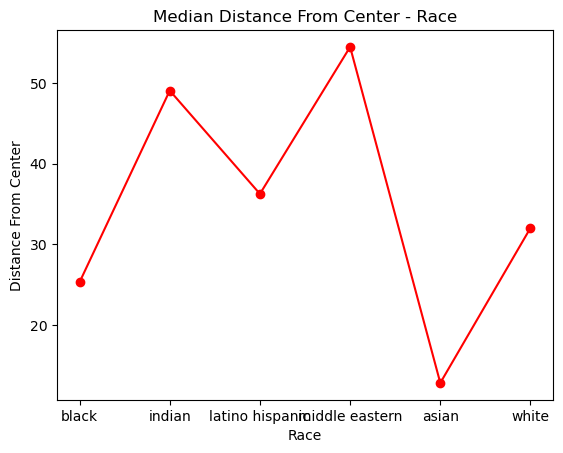

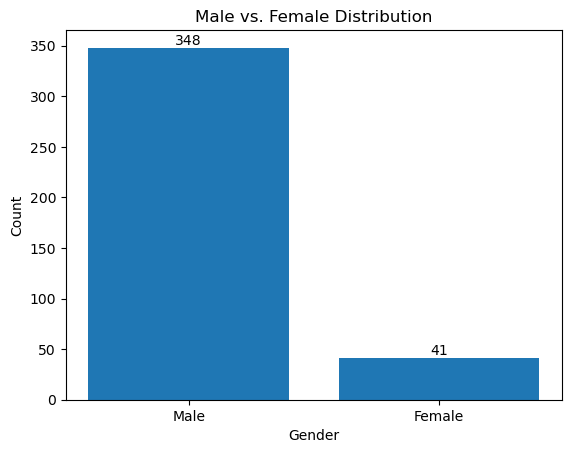

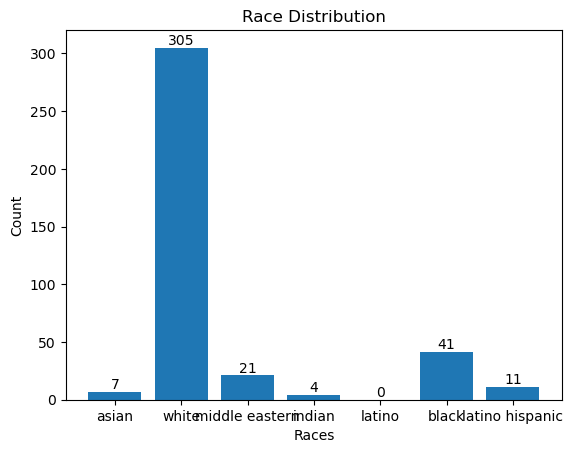

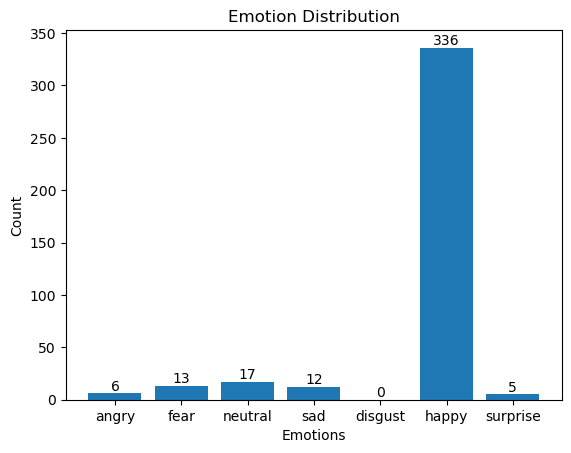

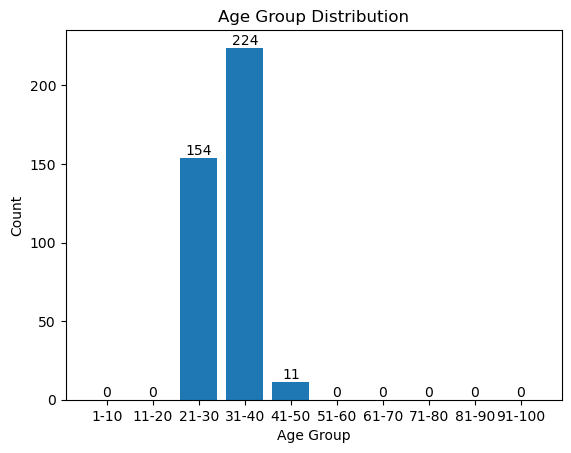

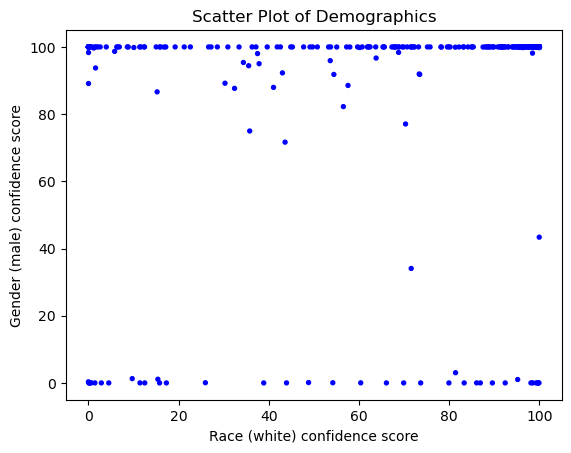

In [23]:
MetricCenterDistanceDisplay(DeepFaceDict, distance_val_list=dist_bet_centers, area_val_list=space_taken_up, category='race', type='distance')
MetricGenderDisplay(DeepFaceDict, specific_race=None, specific_emotion=None, specific_age=None)
MetricRaceDisplay(DeepFaceDict, specific_gender=None, specific_emotion=None, specific_age=None)
MetricEmotionDisplay(DeepFaceDict,  specific_gender=None, specific_race=None, specific_age=None)
MetricAgeDisplay(DeepFaceDict, specific_gender=None, specific_race=None, specific_emotion=None)
ScatterPlotDisplay2D(DeepFaceDict, x_axis_label="race", y_axis_label="gender", specific_gender="male", specific_race="white", specific_emotion=None)
ScatterPlotDisplay3D(DeepFaceDict, specific_gender="male", specific_race="white")
# ImageInfoDisplay(DeepFaceDict)

# Merler et al. Bias Metric

$ShannonEntropy(X) = -\sum_{i=1}^{n}P(X=x_{i})\cdot ln(P(X=x_{i}))$

$SimpsonIndex(X) = \frac{1}{\sum_{i=1}^{n}P(X=x_{i})^2}$

$Evenness_{Shannon} = \frac{H(X)}{ln(n)}$

$Evenness_{Simpson} = \frac{D(X)}{n}$

In [24]:
def ShannonSimpsonMetrics(data):
    prob_gender = {"male": 0, "female": 0}
    prob_race = {"asian": 0, "white": 0, "middle eastern": 0, "indian": 0, "latino hispanic": 0, "black": 0}
    prob_emotion = {"angry": 0, "fear": 0, "neutral": 0, "sad": 0, "disgust": 0, "happy": 0, "surprise": 0}
    prob_age = {"0-2":0,"3-9":0,"10-19":0,"20-29":0,"30-39":0,"40-49":0,"50-59":0,"60-69":0,"70+":0}
    dict_list = [prob_gender, prob_race, prob_emotion, prob_age]

    # Working out the number of each metric present across the set of images
    for index in range(len(data)):
        prob_gender[data[index][1]["gender"]] += 1

        prob_race[data[index][1]["race"]] += 1

        prob_emotion[data[index][1]["emotion"]] += 1

        if data[index][1]["age"] in range(0,3): 
            prob_age["0-2"] += 1
        elif data[index][1]["age"] in range(3,10):
            prob_age["3-9"] += 1
        elif data[index][1]["age"] in range(10,20):
            prob_age["10-19"] += 1
        elif data[index][1]["age"] in range(20,30):
            prob_age["20-29"] += 1
        elif data[index][1]["age"] in range(30,40):
            prob_age["30-39"] += 1
        elif data[index][1]["age"] in range(40,50):
            prob_age["40-49"] += 1
        elif data[index][1]["age"] in range(50,60):
            prob_age["50-59"] += 1
        elif data[index][1]["age"] in range(60,70):
            prob_age["60-69"] += 1
        elif data[index][1]["age"] >= 70:
            prob_age["70+"] += 1

    # Working out the probability that each metric is present across the set of images
    for dict in dict_list:
        for item in dict:
            dict[item] /= len(data)

    # Working out the shannon entropy for each metric
    shannonEntropy = {"gender":0, "race":0, "emotion":0, "age":0}
    for index, dict in enumerate(dict_list):
        shannon_val = 0
        for item in dict:
            # Ignoring 0 values as ln(0) is undefined 
            if dict[item] != 0:
                shannon_val += dict[item]*math.log(dict[item])
        shannon_val = -shannon_val
        shannonEntropy[list(shannonEntropy.keys())[index]] = shannon_val
    print("ShannonEntropy: ", shannonEntropy)

    simpsonIndex = {"gender":0, "race":0, "emotion":0, "age":0}
    for index, dict in enumerate(dict_list):
        simpson_val = 0
        for item in dict:
            simpson_val += dict[item]**2
        simpson_val = 1/simpson_val
        simpsonIndex[list(simpsonIndex.keys())[index]] = simpson_val
    print("SimpsonIndex: ", simpsonIndex)

    shannonEvenness = shannonEntropy.copy()
    gender_count = sum(1 for value in prob_gender.values() if value > 0)
    race_count = sum(1 for value in prob_race.values() if value > 0)
    emotion_count = sum(1 for value in prob_emotion.values() if value > 0)
    age_count = sum(1 for value in prob_age.values() if value > 0)

    if shannonEvenness["gender"] != 0:
        shannonEvenness["gender"] /= math.log(gender_count)

    if shannonEvenness["race"] != 0:
        shannonEvenness["race"] /= math.log(race_count)

    if shannonEvenness["emotion"] != 0:
        shannonEvenness["emotion"] /= math.log(emotion_count)

    if shannonEvenness["age"] != 0:
        shannonEvenness["age"] /= math.log(age_count)
    print("ShannonEvenness: ", shannonEvenness)

    simposonEvenness = simpsonIndex.copy()
    simposonEvenness["gender"] /= gender_count
    simposonEvenness["race"] /= race_count
    simposonEvenness["emotion"] /= emotion_count
    simposonEvenness["age"] /= age_count
    print("SimpsonEvenness: ", simposonEvenness)

    return {"ShannonEntropy":shannonEntropy, "SimpsonIndex":simpsonIndex, "ShannonEvenness":shannonEvenness, "SimpsonEvenness":simposonEvenness}


In [25]:
ShannonSimpsonMetrics(DeepFaceDict)

ShannonEntropy:  {'gender': 0.33678521072283274, 'race': 0.8056618261866266, 'emotion': 0.6045177898431582, 'age': 0.749696414747054}
SimpsonIndex:  {'gender': 1.2324062385470538, 'race': 1.5872887667439397, 'emotion': 1.3325319877772785, 'age': 1.8965145571444686}
ShannonEvenness:  {'gender': 0.48587835335457535, 'race': 0.4496484266014403, 'emotion': 0.33738780245074024, 'age': 0.682403084764271}
SimpsonEvenness:  {'gender': 0.6162031192735269, 'race': 0.2645481277906566, 'emotion': 0.22208866462954643, 'age': 0.6321715190481562}


{'ShannonEntropy': {'gender': 0.33678521072283274,
  'race': 0.8056618261866266,
  'emotion': 0.6045177898431582,
  'age': 0.749696414747054},
 'SimpsonIndex': {'gender': 1.2324062385470538,
  'race': 1.5872887667439397,
  'emotion': 1.3325319877772785,
  'age': 1.8965145571444686},
 'ShannonEvenness': {'gender': 0.48587835335457535,
  'race': 0.4496484266014403,
  'emotion': 0.33738780245074024,
  'age': 0.682403084764271},
 'SimpsonEvenness': {'gender': 0.6162031192735269,
  'race': 0.2645481277906566,
  'emotion': 0.22208866462954643,
  'age': 0.6321715190481562}}

# Zhao et al. Bias Metric 
$b(o,g) =  \frac{c(o,g)}{\sum_{x \in \{g_1...g_n\}}c(o,x)}$

In [2]:
# How To Use
# 1. Load Images of a particular type (e.g. doctor)
# 2. Run the code below to get the correlation between o (e.g. doctor) and the metrics G (e.g. male/female), 
#    the correlation is the  number of occurrences of o and g in a corpus.
# 3. Finally, check if the correlations is greater than 1/G, if yes than o is positively correlated with g and may exhibit bias

def CorrelationMetric(data):
    correlation_gender = {"male": 0, "female": 0}
    correlation_race = {"asian": 0, "white": 0, "middle eastern": 0, "indian": 0, "latino hispanic": 0, "black": 0}
    correlation_emotion = {"angry": 0, "fear": 0, "neutral": 0, "sad": 0, "disgust": 0, "happy": 0, "surprise": 0}
    correlation_age = {"0-2":0,"3-9":0,"10-19":0,"20-29":0,"30-39":0,"40-49":0,"50-59":0,"60-69":0,"70+":0}
    dict_list = [correlation_gender, correlation_race, correlation_emotion, correlation_age]
    count = len(data)

    # Working out the number of each metric present across the set of images
    for index in range(len(data)):
        correlation_gender[data[index][1]["gender"]] += 1

        correlation_race[data[index][1]["race"]] += 1

        correlation_emotion[data[index][1]["emotion"]] += 1

        if data[index][1]["age"] in range(0,3): 
            correlation_age["0-2"] += 1
        elif data[index][1]["age"] in range(3,10):
            correlation_age["3-9"] += 1
        elif data[index][1]["age"] in range(10,20):
            correlation_age["10-19"] += 1
        elif data[index][1]["age"] in range(20,30):
            correlation_age["20-29"] += 1
        elif data[index][1]["age"] in range(30,40):
            correlation_age["30-39"] += 1
        elif data[index][1]["age"] in range(40,50):
            correlation_age["40-49"] += 1
        elif data[index][1]["age"] in range(50,60):
            correlation_age["50-59"] += 1
        elif data[index][1]["age"] in range(60,70):
            correlation_age["60-69"] += 1
        elif data[index][1]["age"] >= 70:
            correlation_age["70+"] += 1

    for dict in dict_list:
        for item in dict:
            # Divide all values in the dictionary by count
            dict[item] /= count
            if dict[item] > 1/len(dict):
                print(item, "is positively correlated with the image type.")

In [27]:
CorrelationMetric(DeepFaceDict)

male is positively correlated with the image type.
female is positively correlated with the image type.
asian is positively correlated with the image type.
white is positively correlated with the image type.
middle eastern is positively correlated with the image type.
indian is positively correlated with the image type.
latino hispanic is positively correlated with the image type.
black is positively correlated with the image type.
angry is positively correlated with the image type.
fear is positively correlated with the image type.
neutral is positively correlated with the image type.
sad is positively correlated with the image type.
happy is positively correlated with the image type.
surprise is positively correlated with the image type.
20-29 is positively correlated with the image type.
30-39 is positively correlated with the image type.
40-49 is positively correlated with the image type.


# No Longer Used Functions

In [ ]:
# # Function used to measure the similarity between two images utilising the MSE
# def ImageSimilarity(img1, img2, threshold=1000):

#     # Checking if the images have the same dimensions
#     # if img1.shape != img2.shape:
#     img1 = cv2.resize(img1, [256,256])
#     img2 = cv2.resize(img2, [256,256])
#         # return False

#     # Calculate the Mean Squared Error (MSE)
#     mse = ((img1 - img2) ** 2).mean()
    
#     print(mse)

#     # Compare MSE with threshold
#     return mse < threshold

In [ ]:
# # Function used to remove duplicate images from list
# def return_non_duplicate_image_indexes(list_images, threshhold=1000):
#     no_duplicate_indexes = []

#     for index in range(len(list_images)):
#         unique = True
#         for index_2 in range(index, len(list_images)):
#             if index != index_2:
#                 if ImageSimilarity(list_images[index], list_images[index_2], threshhold):
#                     unique = False
#                     break

#         if unique:
#             no_duplicate_indexes.append(index)

#     return no_duplicate_indexes

In [ ]:
# Code-Link: https://colab.research.google.com/github/rom1504/clip-retrieval/blob/master/notebook/clip-client-query-api.ipynb#scrollTo=LtInBZF-vTuE
# https://github.com/rom1504/clip-retrieval

# Function used to retrive image links from the LAION-5B dataset
# def RetrieveLaion5BImageLinks(text, aes_score, aes_weight, num_of_images):
#     """ 
#     Description:
#     This function is used to retrieve the image links from the LAION-5B dataset, which coencide with the passed parameters.
    
#     Parameters:
#     text (str) - Text to query the dataset.
#     aes_score (float) - Aesthetic score of the images to retrieve.
#     aes_weight (float) - Aesthetic weight of the images to retrieve.
#     num_of_images (int) - Number of images to retrieve.

#     Returns:
#     img_result (list) - List containing the resultant image links.
#     """

#     # Connecting to the Clip client
#     client = ClipClient(
#         url="https://knn.laion.ai/knn-service",
#         indice_name="laion5B-H-14",
#         aesthetic_score=aes_score,
#         aesthetic_weight=aes_weight,
#         modality=Modality.IMAGE,
#         num_images=num_of_images,
#         deduplicate=True,
#     )
    
#     # Retrieving the image links based on the text query
#     img_result = client.query(text)
        
#     return img_result

In [ ]:
# # Function used to combine the functionality of the RetrieveImages & RetrieveImagesFromLinks functions
# # Note: This function ensures that the requested number of images are retrieved irrelevant of any errors 
# # and provides the added functionality of saving the images retrieved to disk
# # Note: Requesting too many images will result in errors, if the specified numebr of images doesn't exist
# def RetrieveImagesLAION(text, aes_score, aes_weight, num_of_images, save_images):
#     """ 
#     Description:
#     This function serves to combine the RetrieveImageLinks and RetrieveImagesFromLinks functions for ease of use. 
#     Unlike the independet function this function ensures that the requested number of images are retrieved irrelevant of any errors.
    
#     Parameters:
#     text (str) - Text to query the dataset.
#     aes_score (float) - Aesthetic score of the images to retrieve.
#     aes_weight (float) - Aesthetic weight of the images to retrieve.
#     num_of_images (int) - Number of images to retrieve.
#     save_images (bool) - Boolean value to determine if the images should be saved to disk.

#     Returns:
#     images (list) - List containing the retrieved images.
#     """

#     images = []
    
#     # Increasing the number of images required in case some images were failed to be retrieved
#     noImages = num_of_images*2 
    
#     while len(images) < num_of_images:
#         # Retrieving the image urls from LAION-5B dataset
#         image_links = RetrieveLaion5BImageLinks(text, aes_score, aes_weight, noImages)

#         # Retrieving the images from their respective urls
#         images, failedImages = RetrieveImagesFromLinks(image_links)
        
#         # Increasing the number of images required in case some images were failed to be retrieved
#         noImages = noImages*2
    
#     # Removing any extra images 
#     images = images[:num_of_images]
#     print("Out of the ",len(image_links)," image links retrieved ",failedImages," failed to result in an image.")
    
#     if save_images:
#         # Checking if the folder exists, and if not, creating it
#         folder_path = Path("DownloadedImages")
#         if not folder_path.exists():
#             folder_path.mkdir()
    
#         # Checking if the folder exists, and if not, creating it
#         sub_folder_path = Path(os.path.join("DownloadedImages",CamelCase(text)))
#         if not sub_folder_path.exists():
#             sub_folder_path.mkdir()
        
#         # Saving the images to disk
#         for imgIndex in range(len(images)):
#             save_path = os.path.join(sub_folder_path,str(imgIndex)+".jpg")
#             cv2.imwrite(save_path, cv2.cvtColor(images[imgIndex], cv2.COLOR_BGR2RGB))
#     return images

In [ ]:
# # Function used to combine the the functionality of the RetrieveImagesLAION, DeepFaceProcess & ImageInfoDisplay functions
# def SearchQueryFunc(text, aes_score, aes_weight, num_of_images):
#     """ 
#     Description:
#     This function serves to to combine the the functionality of the RetrieveImagesLAION, DeepFaceProcess & ImageInfoDisplay functions for ease of use.
    
#     Parameters:
#     text (str) - Text to query the dataset.
#     aes_score (float) - Aesthetic score of the images to retrieve.
#     aes_weight (float) - Aesthetic weight of the images to retrieve.
#     num_of_images (int) - Number of images to retrieve.

#     Returns:
#     None.
#     """
  
#     list_of_images = RetrieveImagesLAION(text, aes_score, aes_weight, num_of_images, False)  
        
#     # Processign the images via DeepFace API
#     DeepFaceDict = DeepFaceProcess(list_of_images,text,False)
    
#     # Displaying the image & their information
#     ImageInfoDisplay(DeepFaceDict)